# Download and Import Library

In [1]:
# Use seaborn for pairplot.
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.17.1


# Preprocessing Data

## Download MPG auto Dataset

In [4]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean Data
---
- Tập dữ liệu chứa một vài dữ liệu `undefined`, drop các hàng để đơn giản hóa.
- Mã hóa cột `Origin` để phân loại.

In [7]:
dataset.isna().sum()
dataset = dataset.dropna()
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


## Split Data
---
- Chia dữ liệu thành 2 tập `Train` và `Test`.
- `Train`: huấn luyện mô hình.
- `Test`: kiểm tra mô hình.

In [8]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Inspect Data
---
- Xem lại cách phân phối một số cột của dữ liệu.
- Kiểm tra số liệu thống kê tổng thể.



,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


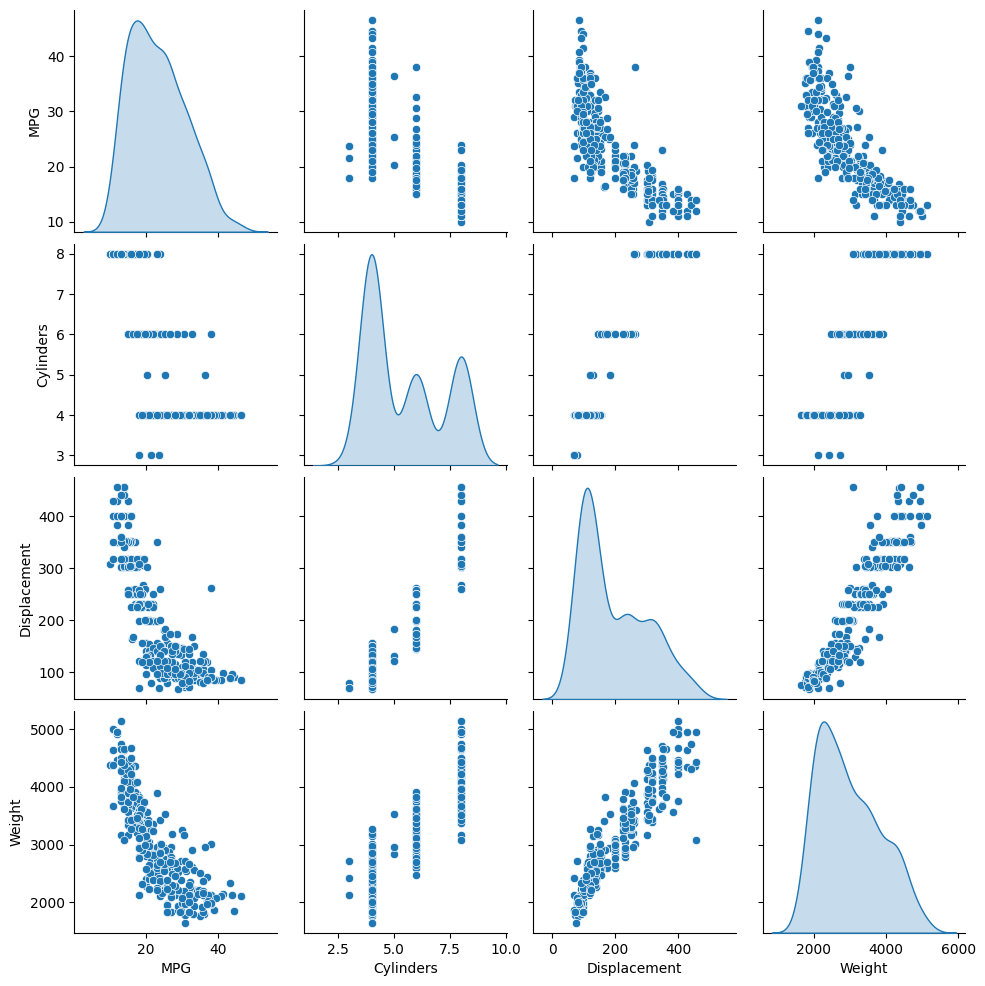

In [9]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')
train_dataset.describe().transpose()

## Split Feature out of Labels
---
- Giá trị mục tiêu bài toán(trong bài này là `MPG`) tách ra khỏi *nhãn*
 (`labels`) từ các tính năng.
- Nhãn (`labels`): giá trị đào tạo mô hình dự đoán.

In [10]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalization
---

In [11]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


## Normalize Layers
---
- `tf.keras.layers.Normalization`: Thêm tính năng chuẩn hóa tối ưu mô hình.
- Các bước thực hiện:
    * Tạo lớp chuẩn hóa.
    * `Normalization.adapt`: Điều chỉnh trạng thái lớp tiền xử lí với dữ liệu.
    * Tính giá trị trung bình và phương sai lưu trong *lớp* (`Class`).
    * Khi lớp được gọi, nó trả về dữ liệu đầu vào, với mỗi tính năng được chuẩn hóa độc lập.

In [12]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [13]:
normalizer.adapt(np.array(train_features))

In [14]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [16]:
first = np.array(train_features[:1], dtype=np.float32)

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


# Linear Regression
---
**Tổng quan bài toán**
---
- Mục đích bài toàn: Dự đoán `MPG` từ `Horsepower`.
- Xác định kiến trúc: Sử dụng thư viện `Keras` được tích hợp trong `Tensorflow` cụ thể là `tf.keras`.
- Xác định mô hình: Sử dụng mô hình đại diện cho một chuỗi các bước là `Sequential` cụ thể là `tf.keras.Sequential`.
- Các bước trong mô hình:
    * Chuẩn hóa tính năng đầu vào `Horsepower` bằng cách sử dụng lớp tiền xử lí `tf.keras.layers.Normalization`.
    * Áp dụng phép biến đổi tuyến tính *`y = mx + b`* tạo ra lớp đầu ra bằng các xử dụng lớp tuyến tính `tf.keras.layers.Dense`.
- Số lượng đầu vào đặt bằng đối số `input_shape` hoặc tự động khi mô hình chạy đầu tiên.
---
**Quy trình huấn luyện**
---
- Tạo một mảng NumPy làm bằng các tính năng `Horsepower` . Sau đó, khởi tạo `tf.keras.layers.Normalization` và điều chỉnh trạng thái của nó với dữ liệu horsepower.
- Xây dựng mô hình tuần tự Keras.
- Sau khi xây dựng mô hình, hãy cấu hình quy trình đào tạo bằng phương thức `Model.compile` . Các đối số quan trọng nhất để biên dịch là *loss* và trình *optimizer* , vì chúng xác định những gì sẽ được tối ưu hóa ( `mean_absolute_error` ) và cách thức (sử dụng `tf.keras.optimizers.Adam` ).
- Sử dụng Keras `Model.fit` để thực hiện đào tạo trong 100 kỷ nguyên.
- Lưu trữ tiến trình huấn luyện trong biến `History`.
- Hiển thị kết quả huấn luyện.
---

## Linear Regression with One Variable.


In [21]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization)      │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

In [23]:
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


array([[ 0.128],
       [ 0.072],
       [-0.236],
       [ 0.179],
       [ 0.162],
       [ 0.064],
       [ 0.192],
       [ 0.162],
       [ 0.042],
       [ 0.072]], dtype=float32)

In [24]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [25]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 6.18 s, sys: 253 ms, total: 6.44 s
Wall time: 6.89 s


In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.808563,4.213045,95
96,3.807212,4.164696,96
97,3.806010,4.184843,97
98,3.802473,4.189768,98
99,3.802749,4.203238,99


In [27]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

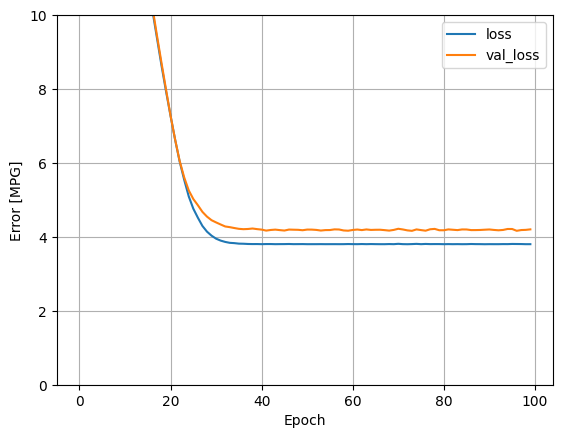

In [28]:
plot_loss(history)

In [29]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [30]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [31]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

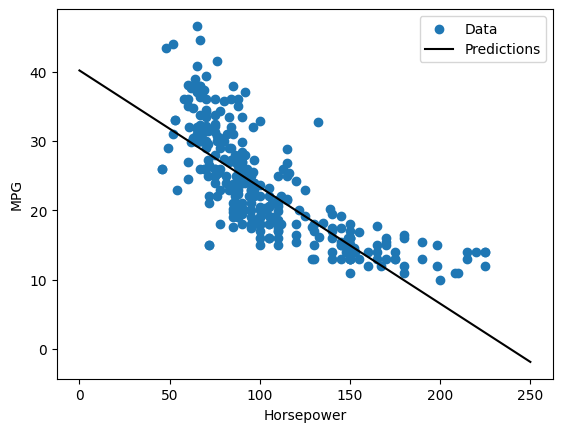

In [32]:
plot_horsepower(x, y)

---
**Đánh giá mô hình**
- Mô hình huấn luyện tốt.
- Kết quả dự đoán cho ra kết quả khả quan.
---

## Linear Regression with Multi-Variable.
---
- Quy trình giống với One Variable nhưng `b` là ma trận vector.
---

In [37]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [38]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


array([[-1.436],
       [-1.118],
       [ 0.668],
       [-3.1  ],
       [ 1.117],
       [-0.899],
       [ 1.132],
       [ 1.387],
       [-0.277],
       [ 3.037]], dtype=float32)

In [39]:
linear_model.layers[1].kernel

<KerasVariable shape=(9, 1), dtype=float32, path=sequential_3/dense_3/kernel>

In [40]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


CPU times: user 6.37 s, sys: 288 ms, total: 6.66 s
Wall time: 6.98 s


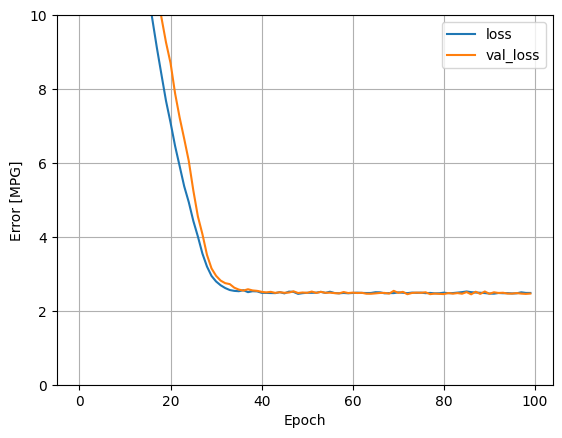

In [41]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

plot_loss(history)

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)


# Linear Regression with Deep Neural Network (DNN)

---
**Tổng quan bài toán**
---
- Giống với Linear Regression cơ bản, nhưng thêm một số lớp phi tuyến tính *ẩn*.
- `hidden`: Các lớp không được kết nối trực tiếp với đầu vào hoặc đầu ra.
---
**Quy trình huấn luyện**
---
- Về cơ bản sẽ giống Linear Regression cơ bản, nhưng có thêm nhiều lớp hơn:
 * Lớp chuẩn hóa.
 * Hai lớp ẩn, phi tuyến tính (`Dense` với hàm kích hoạt ReLU `relu` phi tuyến tính).
 * Một lớp đầu ra đơn `Dense` tuyến tính,
---

*Build And Compile*
---

In [42]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

**One Input**
---

In [43]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [44]:
dnn_horsepower_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization)      │ (None, 1)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

In [45]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 7.86 s, sys: 243 ms, total: 8.1 s
Wall time: 11.1 s


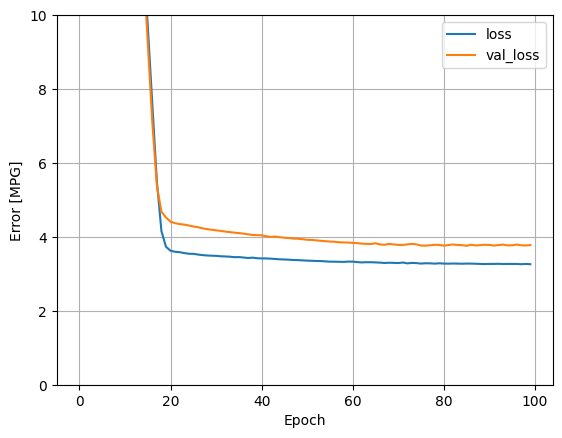

In [46]:
plot_loss(history)

In [47]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


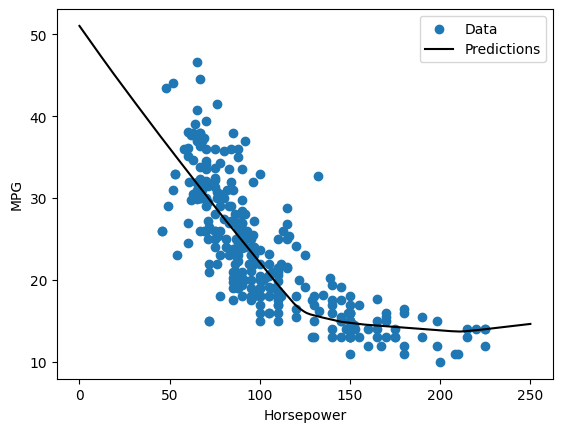

In [48]:
plot_horsepower(x, y)

In [49]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

**Multi-Input**
---

In [50]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (10, 9)                     │              19 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

In [51]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 7.28 s, sys: 297 ms, total: 7.57 s
Wall time: 7.78 s


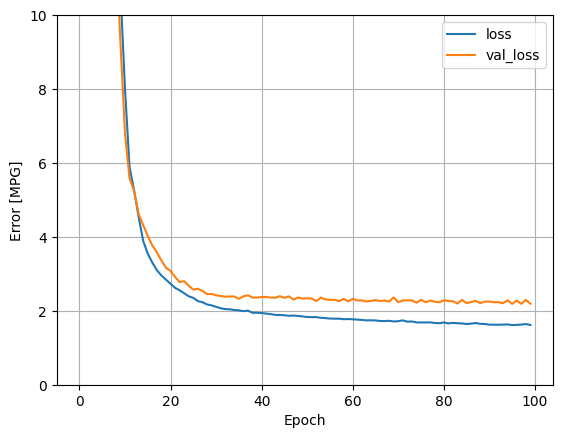

In [52]:
plot_loss(history)

In [53]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

# Evaluate Model

In [54]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.654642
linear_model,2.505648
dnn_horsepower_model,2.931935
dnn_model,1.759964


 # Predict

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


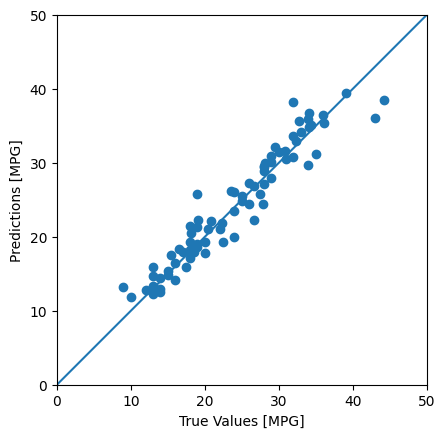

In [55]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

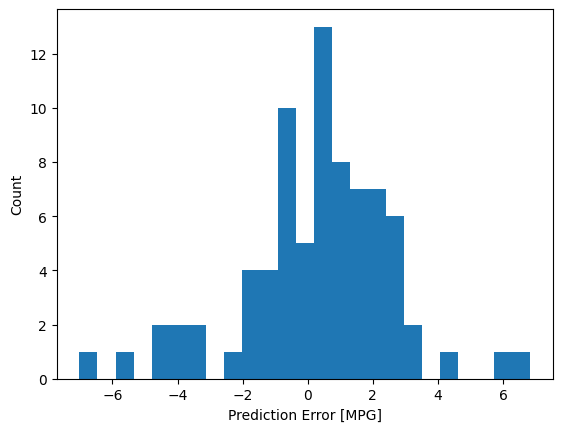

In [56]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

# Save Model And Use Model to Predict

In [ ]:
dnn_model.save('dnn_model')

In [ ]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T